In [1]:
%pip install mtcnn
import cv2
import torch
import numpy as np
from mtcnn import MTCNN
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn

def run_model(input_image_path, output_image_path):
  # Load trained model
  model = torch.load('/content/model_MK1')
  model.eval()
  model.to(torch.device('cuda'))
  model = torch.jit.script(model)

  # Load emotion labels
  emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

  # Load and preprocess the input image
  input_image = cv2.imread(input_image_path)
  gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

  # Initialize MTCNN for face detection
  mtcnn = MTCNN()

  # Detect faces in the image
  faces = mtcnn.detect_faces(input_image)

  for face_info in faces:
      x, y, w, h = [int(coord) for coord in face_info['box']]
      face = gray_image[y:y + h, x:x + w]

      # Preprocess the face image
      face = cv2.resize(face, (48, 48))
      face_tensor = transforms.ToTensor()(face).unsqueeze(0).to(torch.device('cuda'))

      with torch.no_grad():
          predictions = model(face_tensor)
      predicted_emotion = emotion_labels[predictions.argmax()]

      cv2.rectangle(input_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(input_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

  # Display or save the output image
  cv2.imwrite(output_image_path, input_image)
  plt.imshow(input_image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 7)  # 7 classes for different emotions
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:00


2/2 [==============================] - 0s 117ms/step


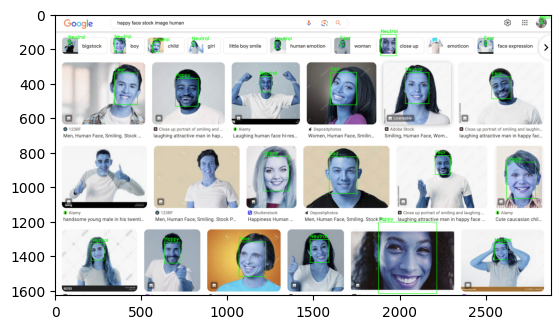

In [2]:
run_model('/content/happy_test.png', '/content/results/happy_result.png')

2/2 [==============================] - 1s 254ms/step


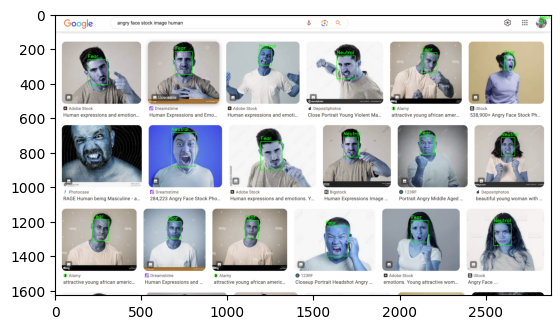

In [3]:
run_model('/content/angry_test.png', '/content/results/angry_result.png')

2/2 [==============================] - 1s 307ms/step


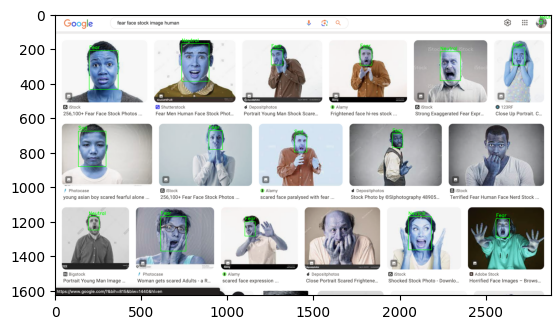

In [4]:
run_model('/content/fear_test.png', '/content/results/fear_result.png')

2/2 [==============================] - 0s 142ms/step


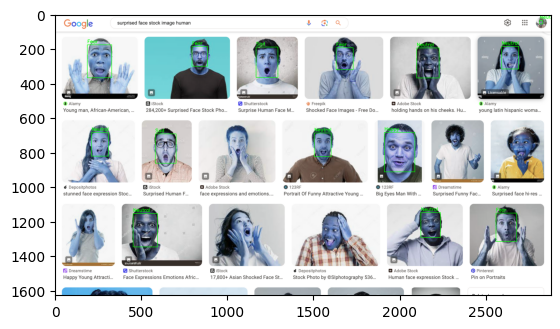

In [5]:
run_model('/content/surprised_test.png', '/content/results/surprised_result.png')

2/2 [==============================] - 0s 7ms/step


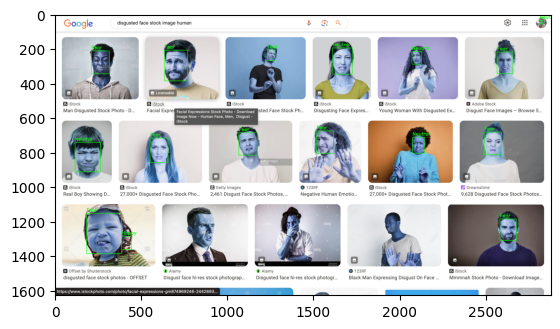

In [6]:
run_model('/content/disgusted_test.png', '/content/results/disgusted_result.png')

2/2 [==============================] - 0s 6ms/step


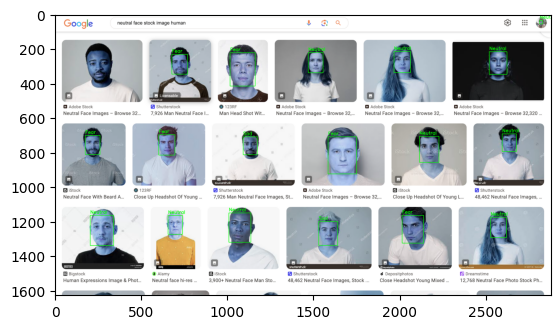

In [7]:
run_model('/content/neutral_test.png', '/content/results/neutral_result.png')